# Using the AnalyzeTimeSeries Class

This class contains a set of methods to create a database of data associated with KPF observations, as well as methods to ingest data, query the database, print data, and made time series plots.  An elaborate set of standard time series plots can be made over intervals of days/months/years/decades spanning a date range.  A related script 'ingest_kpf_ts_db.py' can be used to ingest data from the command line.
        
The ingested data comes from L0/2D/L1/L2 keywords, the TELEMETRY extension in L0 files, and the RV extension in L2 files.  With the current version of this code, all TELEMETRY keywords are added to the database and a small subset of the L0/2D/L1/L2 keywords are added. These lists can be expanded, but will require re-ingesting the data (which takes about half a day for all KPF observations).

The first step is importing packages.

In [1]:
from modules.quicklook.src.analyze_time_series import AnalyzeTimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import numpy as np
import time
import matplotlib.dates as mdates
from datetime import datetime
from astropy.table import Table

## Database Ingestion

The AnalyzeTimeSeries class uses an sqlite3 database stored in a file.  It is is initiated as shown below.  As you can see, the database is fresh because the file `kpf_ts.db` didn't exist. 

In [2]:
db_path = 'kpf_ts.db' # name of database file
myTS = AnalyzeTimeSeries(db_path=db_path)

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/docs/source/tutorials/kpf_ts.db
INFO: Base data directory: /data/L0
INFO: Summary: 0 obs x 331 cols over 0 days in None-None; updated None


Data can be ingested into the database using several methods.  The first method is one observation at a time.

In [3]:
myTS.ingest_one_observation('/data/L0/20240101/','KP.20240101.68255.36.fits')
myTS.print_db_status()

INFO: Summary: 1 obs x 331 cols over 1 days in 20240101-20240101; updated 2024-05-02 17:54:08


Second, one can ingest over a range of dates.  This command will take a few minutes to run, but rerunning it will only take a few seconds once the observations are ingested into the database.

In [4]:
start_date = '20240401'
end_date   = '20240405'
myTS = AnalyzeTimeSeries(db_path=db_path)
myTS.ingest_dates_to_db(start_date, end_date)
myTS.print_db_status()

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/docs/source/tutorials/kpf_ts.db
INFO: Base data directory: /data/L0
INFO: Summary: 1 obs x 331 cols over 1 days in 20240101-20240101; updated 2024-05-02 17:54:08
INFO: Adding to database between 20240401 to 20240405


20240401:   0%|          | 0/5 [00:00<?, ?it/s]

Files:   0%|          | 0/469 [00:00<?, ?it/s]

Files:   0%|          | 0/526 [00:00<?, ?it/s]

Files:   0%|          | 0/530 [00:00<?, ?it/s]

Files:   0%|          | 0/534 [00:00<?, ?it/s]

Files:   0%|          | 0/538 [00:00<?, ?it/s]

INFO: Summary: 2598 obs x 331 cols over 6 days in 20240101-20240405; updated 2024-05-02 18:02:36


The other ingestion methods (not shown) include ingesting based on the ObsIDs from a file (the `add_ObsID_list_to_db()` method) and using the commandline scripts `KPF-Pipeline/scripts/ingest_dates_kpf_tsdb.py` and `KPF-Pipeline/scripts/ingest_watch_kpf_tsdb.py`.

## Database Querying and Display

The database can be queried and displayed.

In [5]:
myTS = AnalyzeTimeSeries(db_path=db_path)
columns_to_display = ['ObsID', 'OBJECT', 'DATE-MID', 'DRPTAG']
myTS.display_dataframe_from_db(columns_to_display)

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/docs/source/tutorials/kpf_ts.db
INFO: Base data directory: /data/L0
INFO: Summary: 2598 obs x 331 cols over 6 days in 20240101-20240405; updated 2024-05-02 18:02:36
                     ObsID            OBJECT                 DATE-MID  DRPTAG
0     KP.20240101.68255.36             SoCal  2024-01-01T18:57:41.372  v2.5.3
1     KP.20240401.11539.63   autocal-thar-hk  2024-04-01T03:12:49.663  v2.6.1
2     KP.20240401.07389.18      autocal-bias  2024-04-01T02:03:09.185  v2.6.1
3     KP.20240401.11431.07   autocal-thar-hk  2024-04-01T03:11:01.081  v2.6.1
4     KP.20240401.07439.02      autocal-bias  2024-04-01T02:03:59.076  v2.6.1
...                    ...               ...                      ...     ...
2593  KP.20240405.86030.41  autocal-flat-all  2024-04-05T23:54:05.417  v2.6.1
2594  KP.20240405.86108.92  autocal-flat-all  2024-04-05T23:55:23.934  v2.6.1
2595  K

Or converted into a Pandas dataframe for manipulation or for making custom plots.

In [6]:
df = myTS.dataframe_from_db(columns_to_display)

## Plotting Telemetry

The AnalyzeTimeSeries has a built-in plotting library that uses dictionaries to pass information.  Here's and example.  Note that `start_date` and `end_date` are formatted as datetime objects, not strings as above.

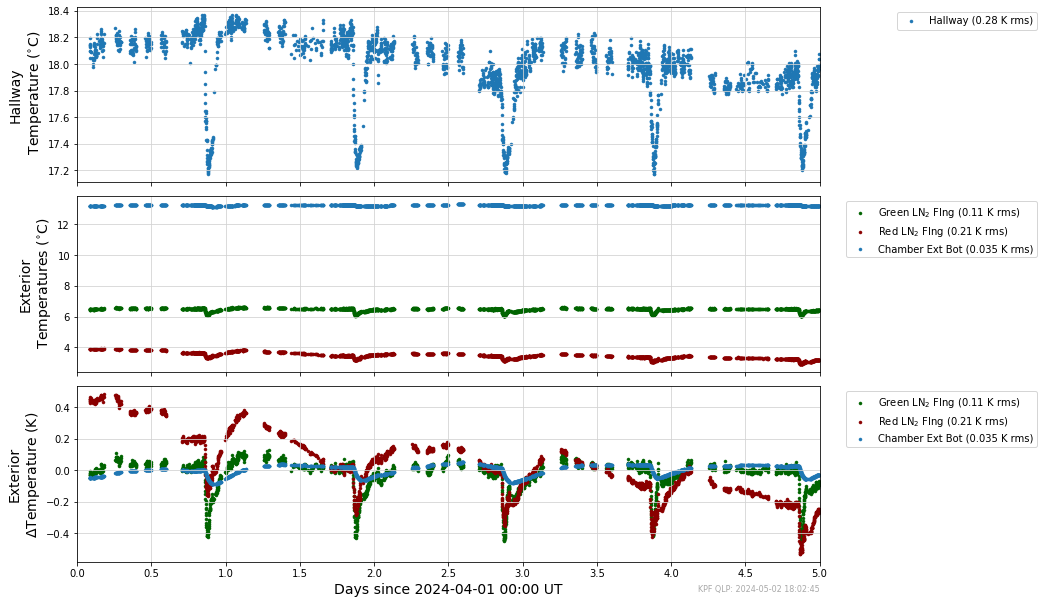

In [7]:
start_date = datetime(2024, 4,  1)
end_date   = datetime(2024, 4,  6)
dict1 = {'col': 'kpfmet.TEMP',              'plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label':  'Hallway',              'marker': '.', 'linewidth': 0.5}}
dict2 = {'col': 'kpfmet.GREEN_LN2_FLANGE',  'plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label': r'Green LN$_2$ Flng',    'marker': '.', 'linewidth': 0.5, 'color': 'darkgreen'}}
dict3 = {'col': 'kpfmet.RED_LN2_FLANGE',    'plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label': r'Red LN$_2$ Flng',      'marker': '.', 'linewidth': 0.5, 'color': 'darkred'}}
dict4 = {'col': 'kpfmet.CHAMBER_EXT_BOTTOM','plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label': r'Chamber Ext Bot',      'marker': '.', 'linewidth': 0.5}}
dict5 = {'col': 'kpfmet.CHAMBER_EXT_TOP',   'plot_type': 'plot',    'unit': 'K', 'plot_attr': {'label': r'Chamber Exterior Top', 'marker': '.', 'linewidth': 0.5}}
thispanelvars = [dict1]
thispaneldict = {'ylabel': 'Hallway\n' + r' Temperature ($^{\circ}$C)',
                 'legend_frac_size': 0.3}
halltemppanel = {'panelvars': thispanelvars,
                 'paneldict': thispaneldict}

thispanelvars2 = [dict2, dict3, dict4]
thispaneldict2 = {'ylabel': 'Exterior\n' + r' Temperatures ($^{\circ}$C)',
                 'legend_frac_size': 0.3}
halltemppanel2 = {'panelvars': thispanelvars2,
                  'paneldict': thispaneldict2}

thispanelvars3 = [dict2, dict3, dict4]
thispaneldict3 = {'ylabel': 'Exterior\n' + r'$\Delta$Temperature (K)',
                 'subtractmedian': 'true',
                 'legend_frac_size': 0.3}
halltemppanel3 = {'panelvars': thispanelvars3,
                  'paneldict': thispaneldict3}

panel_arr = [halltemppanel, halltemppanel2, copy.deepcopy(halltemppanel3)]
myTS.plot_time_series_multipanel(panel_arr, start_date=start_date, end_date=end_date, show_plot=True, clean=True)

There are also a number of built-in standard plots where the dictionaries above are stored in `plot_standard_time_series()`.  Full set of standard plots is listed below.

In [8]:
myTS.plot_all_quicklook(print_plot_names=True)

Plots available in AnalyzeTimeSeries.plot_standard_time_series():
    'hallway_temp': Hallway temperature
    'chamber_temp': Vacuum chamber temperatures
    'chamber_temp_detail': Vacuum chamber temperatures (by optical element)
    'fiber_temp': Fiber scrambler temperatures
    'ccd_readnoise': CCD readnoise
    'ccd_dark_current': CCD dark current
    'ccd_readspeed': CCD read speed
    'ccd_controller': CCD controller temperatures
    'ccd_temp': CCD temperatures
    'lfc': LFC parameters
    'etalon': Etalon temperatures
    'hcl': Hollow-cathode lamp temperatures
    'autocal-flat_snr': SNR of flats
    'hk_temp': Ca H&K Spectrometer temperatures
    'agitator': Agatitator temperatures
    'guiding': FIU Guiding performance of
    'seeing': Seeing measurements for stars
    'observing_snr': SNR of stellar spectra
    'socal_snr': SNR of SoCal spectra
    'socal_rv': RVs from SoCal spectra
    'drptag': DRP Tag
    'drphash': DRP Hash
    'junk_status': Quality control: junk statu

Examples of two built-in standard plots are shown below.

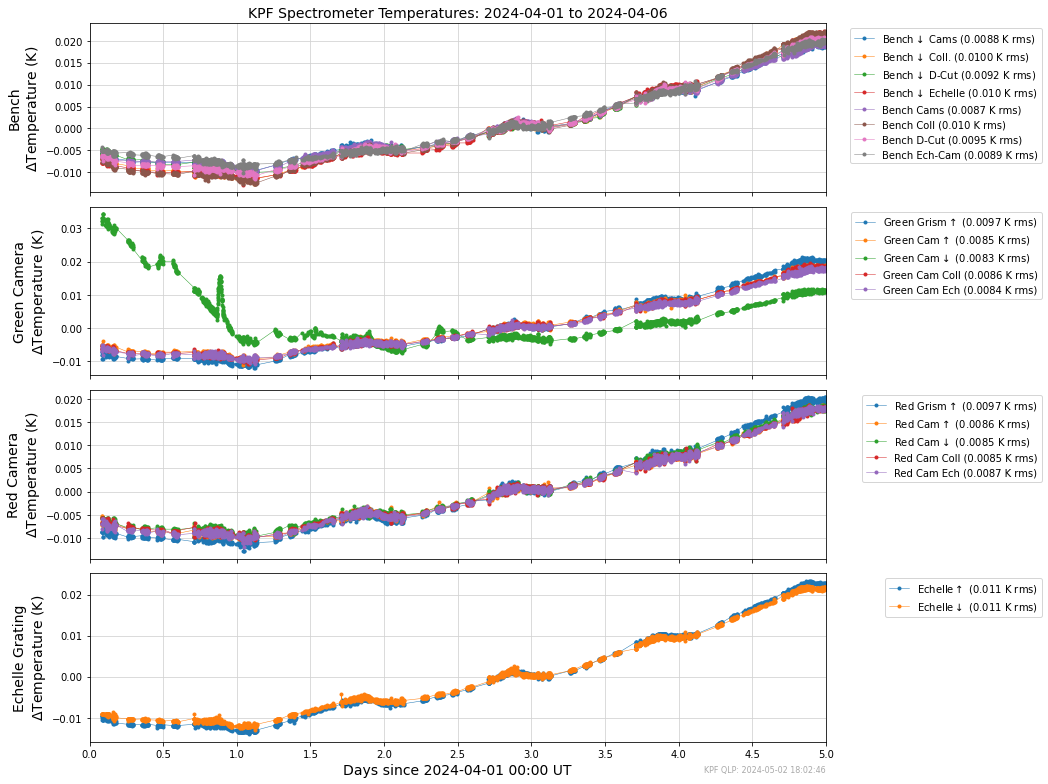

In [9]:
start_date = datetime(2024, 4, 1)
end_date   = datetime(2024, 4, 6)
myTS.plot_standard_time_series('chamber_temp_detail', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

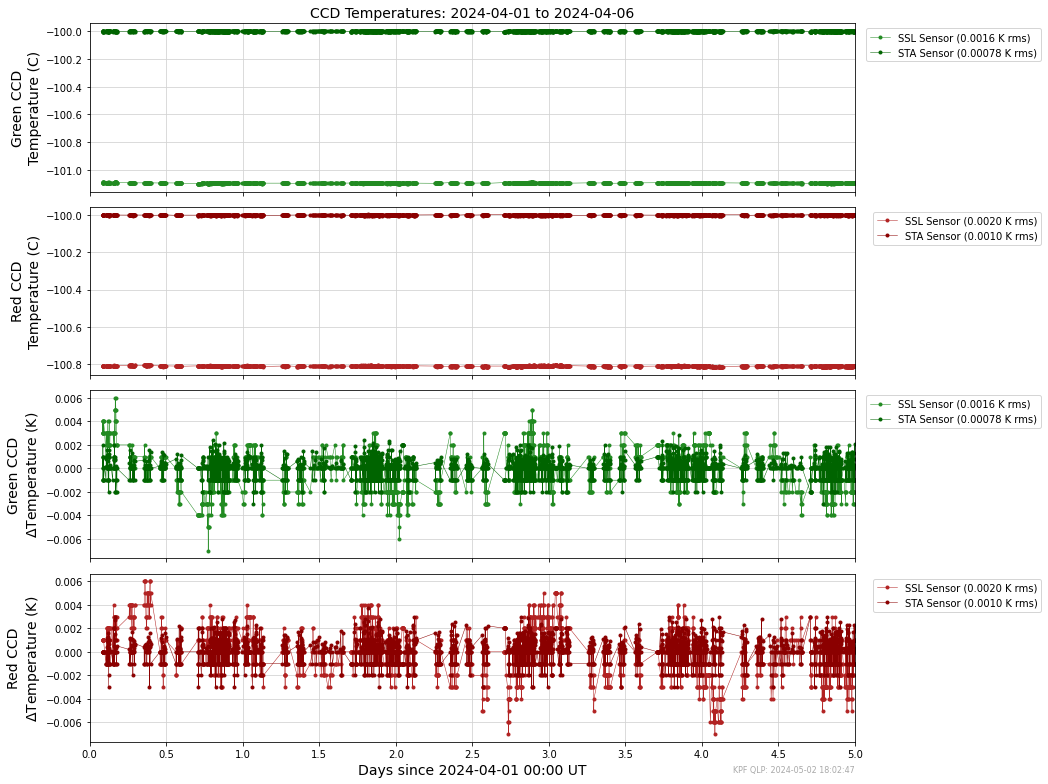

In [10]:
myTS.plot_standard_time_series('ccd_temp', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

The examples above are all plots of float-type variables (e.g., temperatures) over time.  The one below shows examples of state variables changing over time (the DRP version number used to process the data).

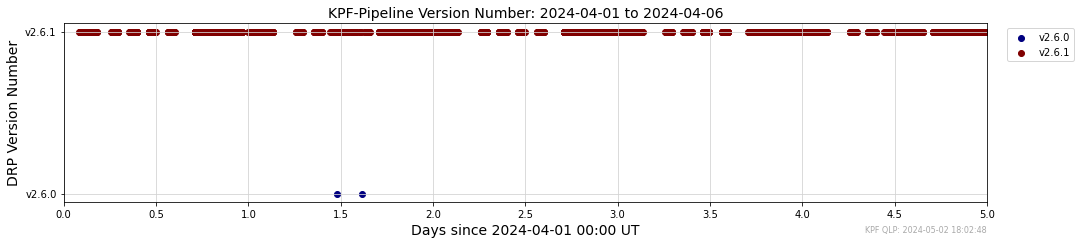

In [11]:
myTS.plot_standard_time_series('drptag', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

One can also generate all plots from the `plot_all_quicklook_daterange()` method with a single call.  The line below is commented out because it generates a large number of plots (a few dozen) that are too much output for this tutorial.  Change `if False` to `if True:` in the line below in your own notebook to generate the output.

In [12]:
if False:
    myTS = AnalyzeTimeSeries(db_path=db_path)
    myTS.plot_all_quicklook(datetime(2024, 4, 1), interval='day', show_plot=True)

## Plotting RVs

An example of plotting RVs (instead of telemetry) is shown below.

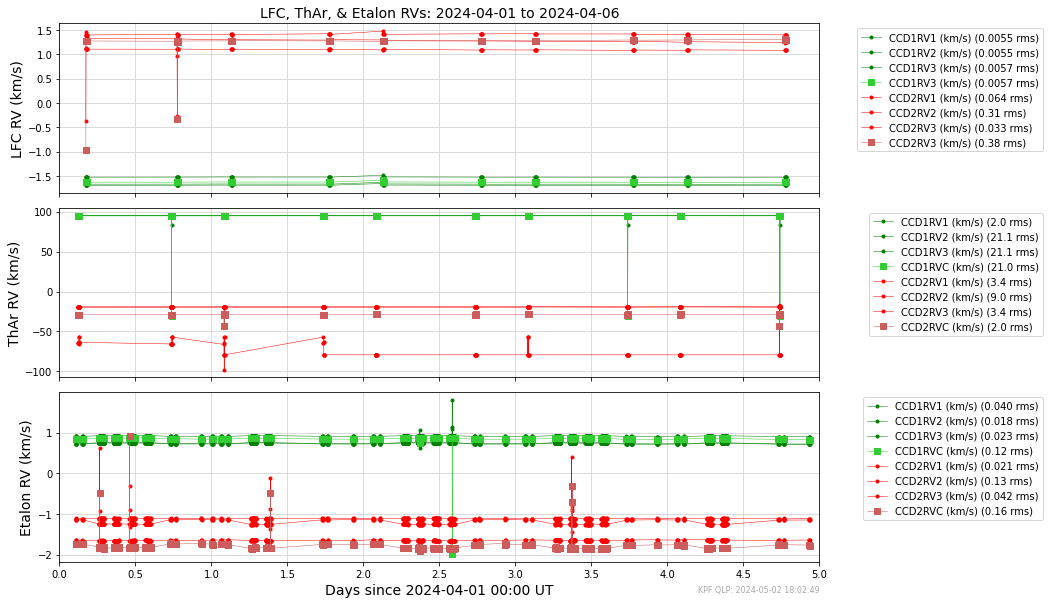

In [13]:
myTS.plot_standard_time_series('autocal_rv', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

Here's an example of plotting SoCal RV and spectral SNR time series.

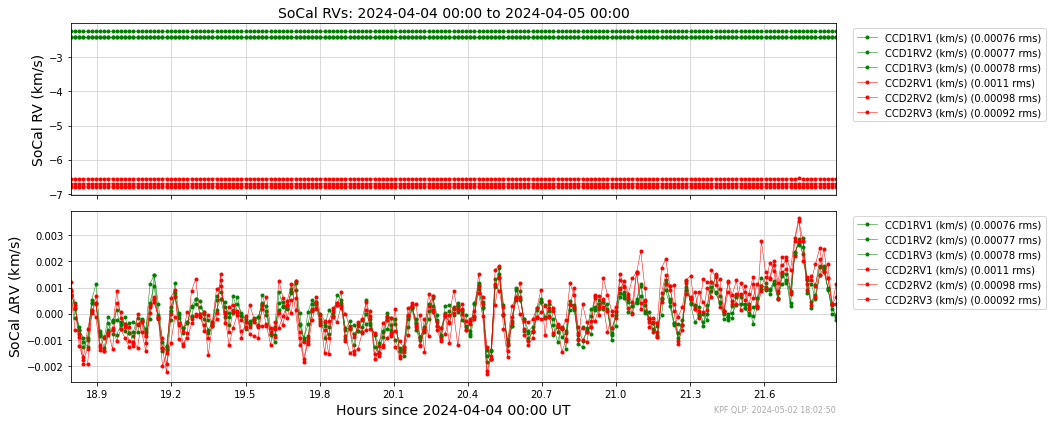

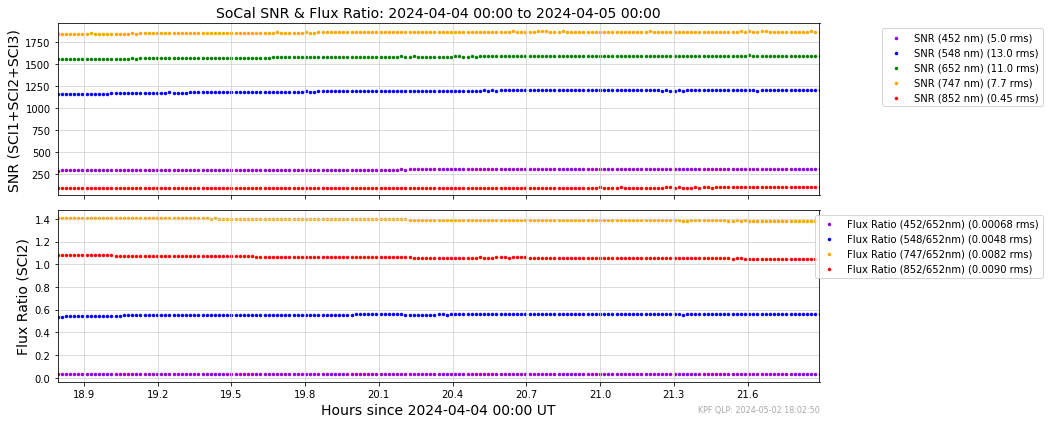

In [14]:
start_date = datetime(2024, 4, 4)
end_date   = datetime(2024, 4, 5)
myTS.plot_standard_time_series('socal_rv',  start_date=start_date, end_date=end_date, show_plot=True, clean=True)
myTS.plot_standard_time_series('socal_snr', start_date=start_date, end_date=end_date, show_plot=True, clean=True)    

One can also plot information about on-sky conditions.

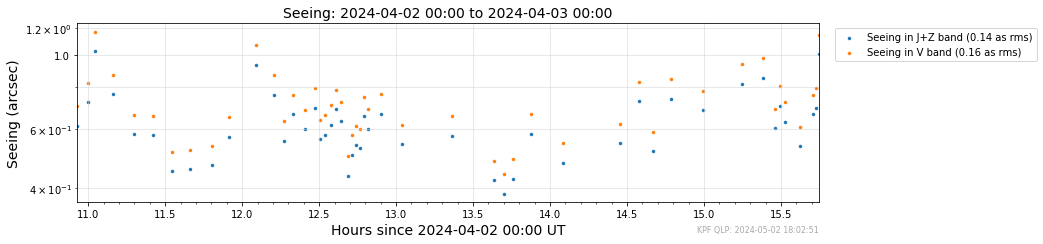

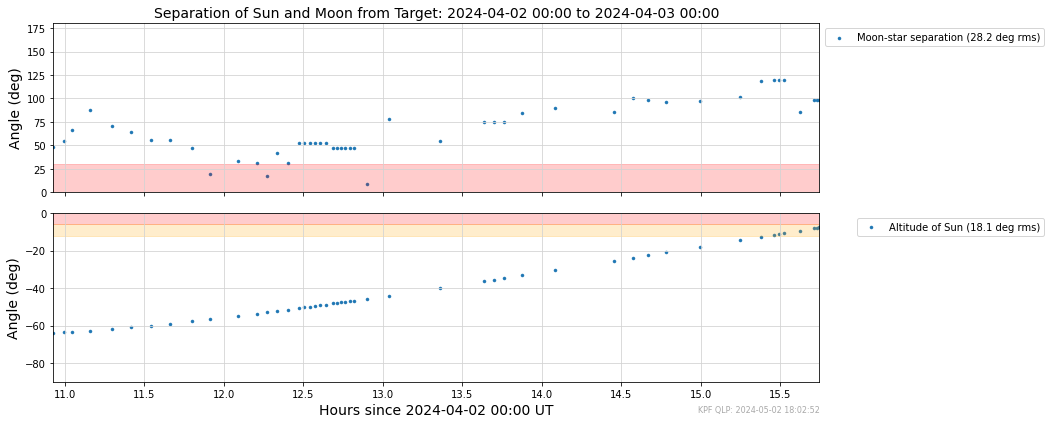

In [15]:
start_date = datetime(2024, 4, 2)
end_date   = datetime(2024, 4, 3)
myTS.plot_standard_time_series('seeing',   start_date=start_date, end_date=end_date, show_plot=True, clean=True)
myTS.plot_standard_time_series('sun_moon', start_date=start_date, end_date=end_date, show_plot=True, clean=True)    